# <center>⚡️🏁 Quick start - тестируем простое решение</center>

In [22]:
!pip install numpy pandas catboost -q
!ls ../data/ # проверяем наличие данных

In [1]:
import numpy as np
import pandas as pd

## Анализируем данные о машинах car_info

🚗 Главное описание машин с информацией о поломках для обучения / прогноза - `car_train.csv` / `car_test.csv`.

**Пояснение столбцов:**
- `car_id` - идентификатор машины
- `model` / `car_type` / `fuel_type`- марка, класс и тип топлива машины
- `car_rating` / `riders` - общий рейтинг  и общее число поездок к концу 2021-го кода.
- `year_to_start` / `year_to_work` - года выпуска машины и начала работы в автопарке 
- `main_city` - город пребывания машины. (Москва или Питер)
- `target_reg` - количество дней до поломки.
- `target_class` - класс поломки (всего 9 видов)

(2337, 10)


,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
1607,a-2141621o,VW Tiguan,economy,petrol,5.08,2013,51808,2018,2294.28,wheel_shake
1124,n10482164t,Kia Rio,economy,petrol,1.96,2015,80512,2019,3468.48,another_bug
1635,L85244434f,Renault Kaptur,standart,petrol,3.04,2012,21873,2018,2147.26,engine_overheat


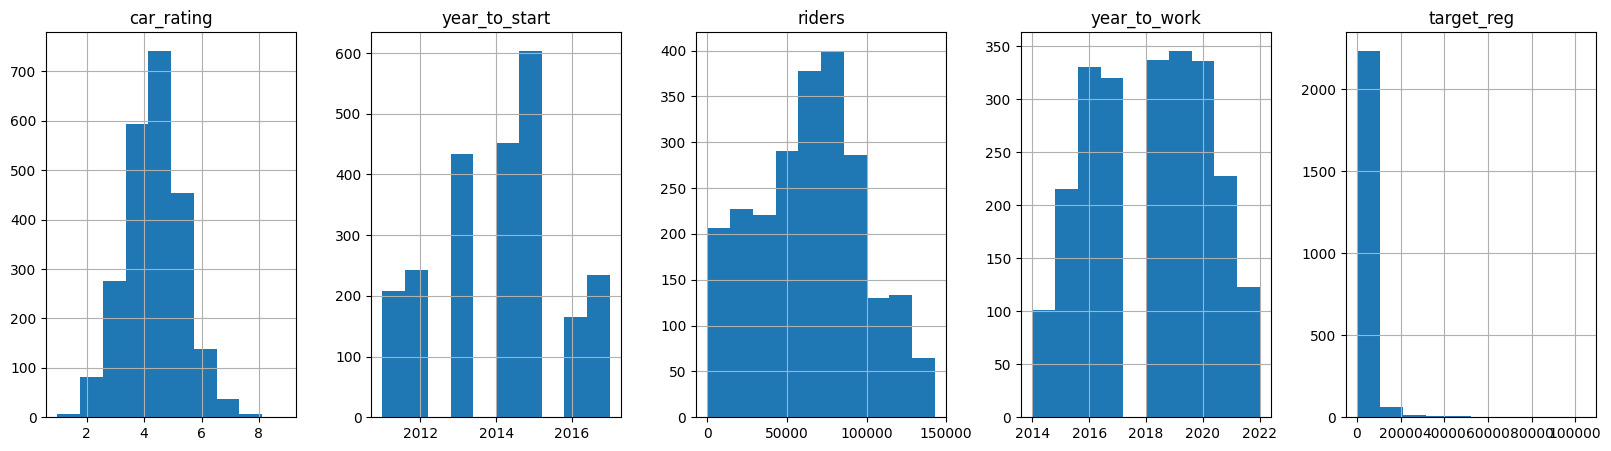

In [2]:
path = '../data/car_train.csv'
train = pd.read_csv(path)
print(train.shape)
train.hist(figsize=(20, 5), layout = (-1, 5))
train.sample(3)

In [4]:
train.describe()

,car_rating,year_to_start,riders,year_to_work,target_reg
count,2337.000000,2337.000000,2337.000000,2337.000000,2337.000000
mean,4.354292,2014.040650,63711.443731,2018.069748,3824.600745
std,0.996954,1.685852,33755.012096,2.159484,6171.887272
min,0.980000,2011.000000,23.000000,2014.000000,225.540000
25%,3.740000,2013.000000,41053.000000,2016.000000,1215.790000
50%,4.360000,2014.000000,64415.000000,2018.000000,2352.100000
75%,5.000000,2015.000000,86515.000000,2020.000000,4334.850000
max,8.900000,2017.000000,142862.000000,2022.000000,104377.420000


In [5]:
path = '../data/car_test.csv'
test = pd.read_csv(path)
print(test.shape)
test.sample(3)

(1913, 8)


,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work
127,a-1510716r,Renault Kaptur,standart,petrol,4.90,2012,18353,2019
1326,M15952724y,Skoda Rapid,economy,petrol,4.02,2015,81242,2016
1670,A13722291q,Skoda Rapid,economy,petrol,3.88,2014,55508,2015
317,F-1966393f,Smart Coupe,economy,petrol,4.96,2015,89045,2019
475,s77766899D,Hyundai Solaris,economy,petrol,4.02,2014,63872,2017


## Классифицируем признаки на типы

In [6]:
features2drop = ['car_id'] # то что надо выбросить 
targets = ['target_class', 'target_reg'] # таргеты
cat_features = ['car_type', 'fuel_type', 'model'] # категориальные признаки

filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]

print('cat_features :', len(cat_features), cat_features)
print('num_features :', len(num_features), num_features)
print('targets', targets)

cat_features : 3 ['car_type', 'fuel_type', 'model']
num_features : 4 ['car_rating', 'year_to_start', 'riders', 'year_to_work']
targets ['target_class', 'target_reg']


## Обучаем Catboost и делаем прогноз на тест

In [23]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score #, mean_squared_error

In [7]:
X = train[filtered_features].drop(targets, axis=1, errors='ignore')
y = train['target_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = CatBoostClassifier(cat_features=cat_features)


clf.fit(X_train, y_train, 
          eval_set=(X_test, y_test),
          verbose=150, plot=False)

# инференс модели
y_pred = clf.predict(X_test)
print(f'\n Accuracy: {accuracy_score(y_test, y_pred)}')

Learning rate set to 0.109335
0:	learn: 2.1911361	test: 2.1951349	best: 2.1951349 (0)	total: 54.2ms	remaining: 54.1s
150:	learn: 1.6539682	test: 2.2440578	best: 2.1908935 (6)	total: 1.47s	remaining: 8.25s
300:	learn: 1.2455381	test: 2.3306861	best: 2.1908935 (6)	total: 3.07s	remaining: 7.14s
450:	learn: 0.9685364	test: 2.4038621	best: 2.1908935 (6)	total: 4.7s	remaining: 5.72s
600:	learn: 0.7432300	test: 2.4962387	best: 2.1908935 (6)	total: 6.41s	remaining: 4.26s
750:	learn: 0.5835086	test: 2.5783601	best: 2.1908935 (6)	total: 8.11s	remaining: 2.69s
900:	learn: 0.4589187	test: 2.6654857	best: 2.1908935 (6)	total: 9.76s	remaining: 1.07s
999:	learn: 0.3990111	test: 2.7166606	best: 2.1908935 (6)	total: 10.8s	remaining: 0us

bestTest = 2.19089351
bestIteration = 6

Shrink model to first 7 iterations.

 Accuracy: 0.0876068376068376


In [8]:
test['target_class'] = clf.predict(test[filtered_features])
test[['car_id', 'target_class']].to_csv('../subs/simple_baseline_v1.csv', index=False)
print('CSV file saved!')

CSV file saved!


## Добавим информацию про поездки из rides_info


🏇 Информация про поездки - `rides_info.csv`.  **Пояснение столбцов:**
- `user_id` / `car_id` / `ride_id` - идентификаторы водителя, машины, поездки соответственно
- `ride_date` / `rating` - дата поездки и рейтинг, поставленный водителем 
- `ride_duration` / `distance` / `ride_cost` -  длительность (время),  пройденное расстояние, стоимость поездки 
- `speed_avg` / `speed_max` - средняя и максимальная скорости поездки соответственно
- `stop_times` / `refueling` - количество остановок (паузы) и флаг - была ли дозаправка.
- `user_ride_quality` - оценка манеры вождения в машины водителя, определенная скоринговой ML системой сервиса.
- `deviation_normal` - общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы). 


In [9]:
path = '../data/rides_info.csv'
rides = pd.read_csv(path)
rides.sample(5)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
294394,A69537309s,U20118110o,h1a,2020-03-25,2.69,60,773,34,100.000000,1,1363.995996,0,12.868106,-49.846
504916,N16357469g,j17565618E,l1N,2020-03-16,7.64,114,1591,40,59.000000,2,2029.002811,0,5.572830,-5.801
632364,g31174407t,s18801959g,Q1q,2020-01-26,4.02,87,1124,48,77.000000,1,960.440449,0,5.727574,6.463
536750,P57111012r,l76478248L,Y1f,2020-03-12,4.67,18,228,42,79.000000,1,634.918855,0,20.767007,2.937
277678,q16329260M,T-4791409E,l1H,2020-03-19,5.42,29,312,48,75.613757,0,1340.290016,0,10.998065,-18.006


In [10]:
f = lambda x: x.nunique()
rides_df_gr = rides.groupby('car_id', as_index=False).agg(mean_rating = ('speed_avg', 'mean'),
                                                   distance_sum = ('distance', 'sum'),
                                                   rating_min = ('rating', 'min'),
                                                   speed_max = ('speed_max', 'max'),
                                                   user_ride_quality_median = ('user_ride_quality', 'median'), 
                                                   deviation_normal_count = ('deviation_normal', 'count'),
                                                   user_uniq = ('user_id', f))


rides_df_gr.head(2)

,car_id,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,A-1049127W,49.459770,1.125753e+07,0.1,179.729652,-0.288229,174,172
1,A-1079539w,49.591954,1.912765e+07,0.1,184.505566,2.508746,174,173


In [11]:
def add_featues(df):
    
    if 'mean_rating' not in df.columns:
        return df.merge(rides_df_gr, on = 'car_id', how = 'left')
    
    return df
    
    
train = add_featues(train)
test = add_featues(test)

In [12]:
train.sample(2)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
367,n-5767544o,Audi A3,premium,petrol,5.28,2017,129974,2019,5330.54,gear_stick,43.839080,1.962930e+07,0.12,107.754497,5.859334,174,170
483,O15208534I,Hyundai Solaris,economy,petrol,2.40,2014,59753,2020,3207.62,engine_ignition,47.522989,1.613637e+07,0.10,190.317387,-7.724325,174,171


In [13]:
train.to_csv('../tmp_data/quickstart_train.csv', index=False)

# Снова обновляем типы фичей

In [14]:
filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]


print('num_features :', len(num_features), num_features)
print('cat_features :', len(cat_features), cat_features)
print('targets', targets)

num_features : 11 ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_ride_quality_median', 'deviation_normal_count', 'user_uniq']
cat_features : 3 ['car_type', 'fuel_type', 'model']
targets ['target_class', 'target_reg']


# Обучаем Catboost на новых данных и делаем новый прогноз

In [15]:
X = train[filtered_features].drop(targets, axis=1, errors='ignore')
y = train['target_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = CatBoostClassifier(cat_features=cat_features)


clf.fit(X_train, y_train, 
          eval_set=(X_test, y_test),
          verbose=150, plot=False)

# инференс модели
y_pred = clf.predict(X_test)
print(f'\n Accuracy: {accuracy_score(y_test, y_pred)}')

Learning rate set to 0.109335
0:	learn: 1.8867428	test: 1.8889315	best: 1.8889315 (0)	total: 7.08ms	remaining: 7.07s
150:	learn: 0.4109407	test: 0.6689167	best: 0.6685302 (142)	total: 1.92s	remaining: 10.8s
300:	learn: 0.2739907	test: 0.6757269	best: 0.6629107 (177)	total: 3.95s	remaining: 9.18s
450:	learn: 0.1950182	test: 0.6935761	best: 0.6629107 (177)	total: 6.02s	remaining: 7.33s
600:	learn: 0.1443841	test: 0.7192890	best: 0.6629107 (177)	total: 8.07s	remaining: 5.36s
750:	learn: 0.1105230	test: 0.7444843	best: 0.6629107 (177)	total: 10.1s	remaining: 3.35s
900:	learn: 0.0880207	test: 0.7643347	best: 0.6629107 (177)	total: 12.2s	remaining: 1.33s
999:	learn: 0.0771231	test: 0.7761287	best: 0.6629107 (177)	total: 13.4s	remaining: 0us

bestTest = 0.6629106773
bestIteration = 177

Shrink model to first 178 iterations.

 Accuracy: 0.7222222222222222


In [16]:
fi = clf.get_feature_importance(prettified=True)
fi

,Feature Id,Importances
0,speed_max,37.390452
1,mean_rating,29.276467
2,rating_min,12.776674
3,model,4.817885
4,car_type,4.339341
5,user_uniq,3.650003
6,user_ride_quality_median,1.742941
7,distance_sum,1.609484
8,riders,1.373459
9,car_rating,1.284999


In [17]:
test['target_class'] = clf.predict(test[filtered_features])
test[['car_id', 'target_class']].to_csv('../subs/simple_baseline_v2.csv', index=False)
print('CSV file saved!')

CSV file saved!


# Что дальше? Зашли решение на Kaggle

- Нажимаем `Save Version`
- Проверяем, что в `Advanced Settings` выбрано - всегда сохранять результаты ноутбука.
- Тип сохранения `Save & Run All (Commit)`
- Жмем окончательно кнопку `Save`